# Kolmogorov-Arnold-Networks

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Time Series Dataset Generation

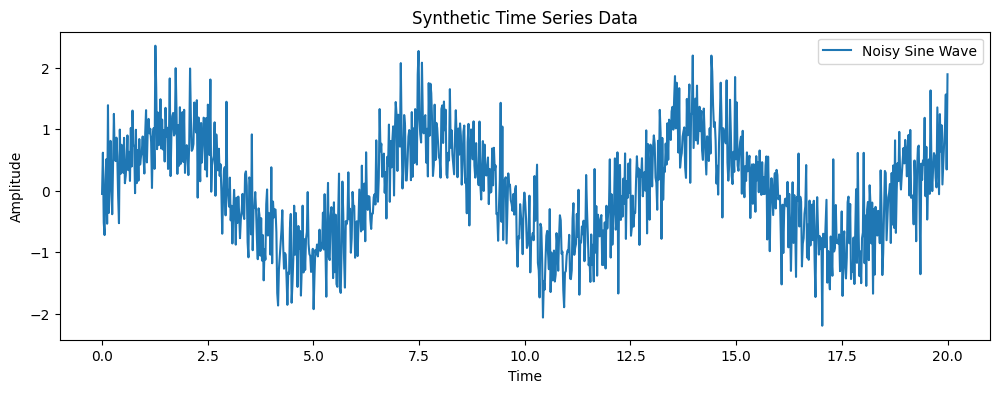

In [2]:
# Generate time points
t = np.linspace(0, 20, 1000)
# Generate random values for the time series
data = np.sin(t) + 0.5 * np.random.randn(1000)

# Plot the generated data
plt.figure(figsize=(12,4))
plt.plot(t, data, label = 'Noisy Sine Wave')
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Data Preparation for Modelling
We use a window size (`n_steps`) of 4, meaning each input sample contains the four previous observations.

In [3]:
# Define the window size.
n_steps = 4

# Create input-output pairs
X = []
Y = []
for i in range(len(data) - n_steps):
    X.append(data[i:i+n_steps])
    Y.append(data[i+n_steps])

X = np.array(X)
Y = np.array(Y)

# Convert to PyTorch Tensors
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Create DataLoaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Implement the MLP

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)

## Implement the KAN

In [5]:
class KAN(nn.Module):
    def __init__(self, input_size):
        super(KAN, self).__init__()
        #Univariate function layers
        self.univariate_function_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
            )
            for _ in range(input_size)
        ])

        #Combining function layers
        self.combine_funcs = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        # Apply univariate function layers
        univariate_outputs = []
        for i in range(x.size(1)):
            xi = x[:, i].unsqueeze(1)
            univariate_output = self.univariate_function_layers[i](xi)
            univariate_outputs.append(univariate_output)
        # Concatenate univariate outputs
        concatenated_outputs = torch.cat(univariate_outputs, dim=1)
        # Apply combining function
        output = self.combine_funcs(concatenated_outputs)
        return output

## Training Function

In [6]:
def train(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
    #Evaluate on test data
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), Y_batch)
                epoch_test_loss += loss.item() * X_batch.size(0)
                
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    return train_losses, test_losses

## Train the MLP model

In [7]:
input_size = n_steps
mlp_model = MLP(input_size)
mlp_train_losses, mlp_test_losses = train(mlp_model, train_loader, test_loader, num_epochs=10, learning_rate=0.001)

Epoch [10/10], Train Loss: 0.2767, Test Loss: 0.3696


## Train the KAN model

In [8]:
kan_model = KAN(input_size)
kan_train_losses, kan_test_losses = train(kan_model, train_loader, test_loader, num_epochs=20, learning_rate=0.001)

Epoch [10/20], Train Loss: 0.2829, Test Loss: 0.3941


Epoch [20/20], Train Loss: 0.2765, Test Loss: 0.3805


## Visualize the Training and Test losses

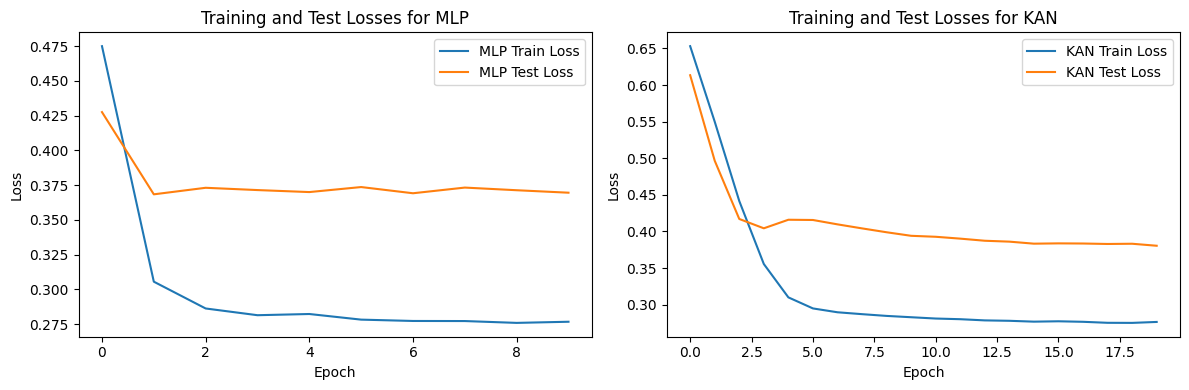

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label='MLP Train Loss')
plt.plot(mlp_test_losses, label='MLP Test Loss')
plt.title('Training and Test Losses for MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(kan_train_losses, label='KAN Train Loss')
plt.plot(kan_test_losses, label='KAN Test Loss')
plt.title('Training and Test Losses for KAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate and Visualize Predictions

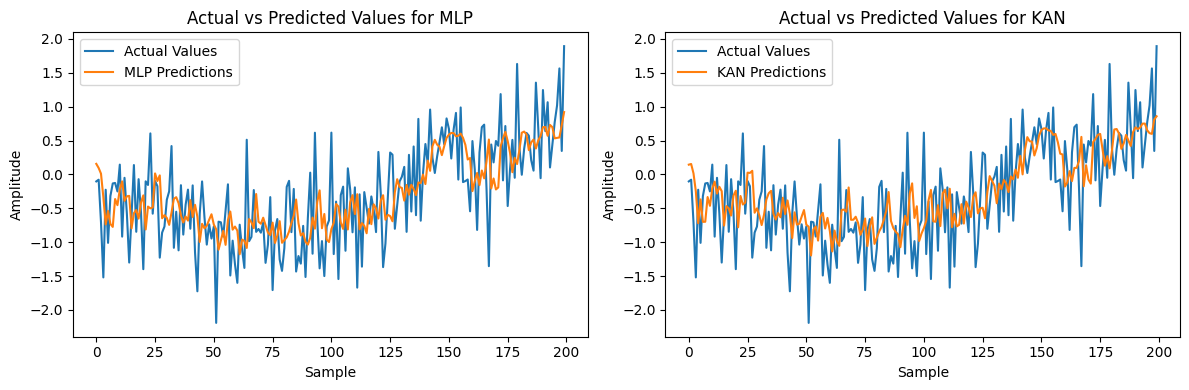

In [10]:
def evaluate_model(model, X_data):
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).squeeze().numpy()
    return predictions

#Get predictions on test data
mlp_predictions = evaluate_model(mlp_model, X_test)
kan_predictions = evaluate_model(kan_model, X_test)

# Actual values
y_actual = Y_test.numpy()

#plot the predictions
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(y_actual, label='Actual Values')
plt.plot(mlp_predictions, label='MLP Predictions')
plt.title('Actual vs Predicted Values for MLP')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_actual, label='Actual Values')
plt.plot(kan_predictions, label='KAN Predictions')
plt.title('Actual vs Predicted Values for KAN')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Error Metrics

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_error_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{model_name} -- MSE: {mse:.4f}, MAE: {mae:.4f}')

print_error_metrics(y_actual, mlp_predictions, 'MLP')
print_error_metrics(y_actual, kan_predictions, 'KAN')

MLP -- MSE: 0.3696, MAE: 0.4979
KAN -- MSE: 0.3805, MAE: 0.5024


##Extract & plot univariate functions

In [12]:
def plot_univariate_functions(kan_model, X_data, feature_names=None):
    num_features = X_data.size(1)
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(num_features)]

    plt.figure(figsize=(12, 8))

    for i in range(num_features):
        #Get the specific univariate function for the feature
        univariate_function = kan_model.univariate_function_layers[i]

        #generate a range of input values
        xi_min = X_data[:, i].min().item()
        xi_max = X_data[:, i].max().item()
        xi_range = torch.linspace(xi_min, xi_max, 100).unsqueeze(1)

        # pass through the univariate function and take the first output
        with torch.no_grad():
            yi = univariate_function(xi_range)[:, 0].squeeze().numpy() #Only take the first output

        #Plot the function
        plt.subplot((num_features + 1) // 2, 2, i + 1)
        plt.plot(xi_range.numpy(), yi, label=f'Feature {i+1}')
        plt.title(f'Univariate Function for {feature_names[i]}')
        plt.xlabel('Input Value')
        plt.ylabel('Output Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Plot the univariate functions

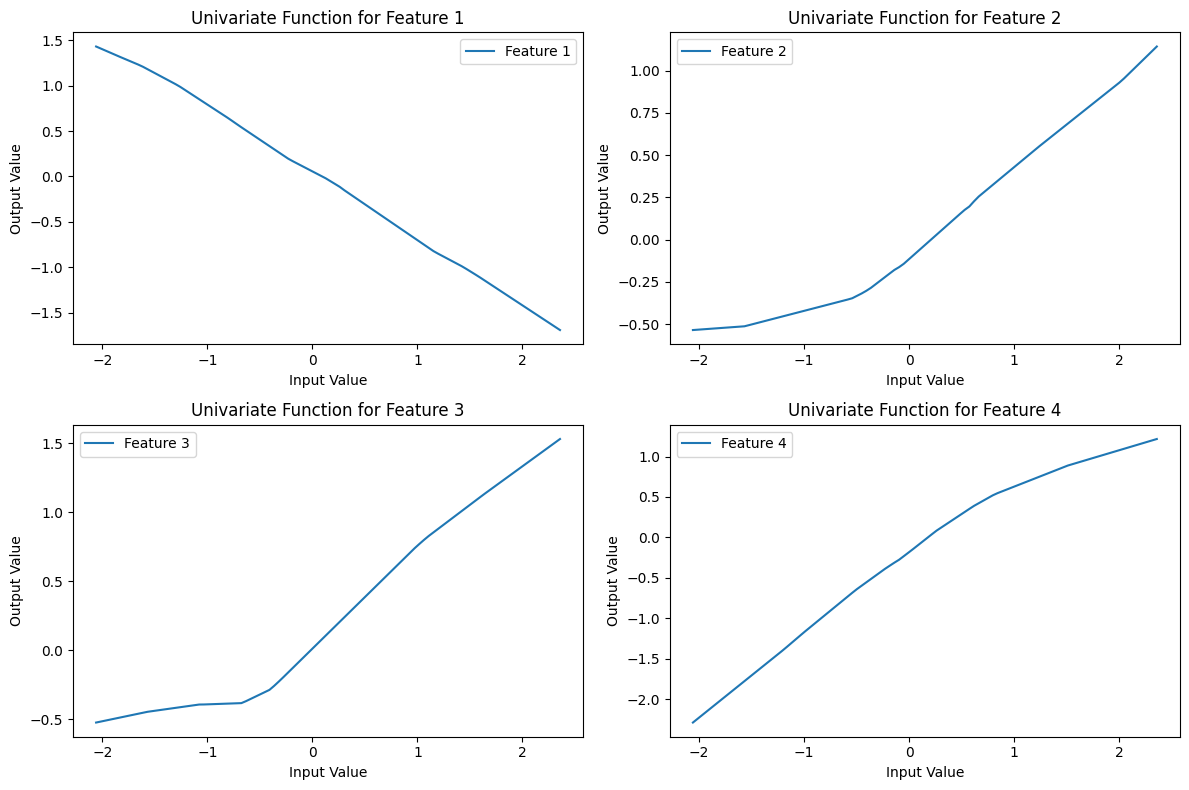

In [13]:
plot_univariate_functions(kan_model, X_train)